# Bird image classification 🦜


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from IPython.display import Image
print(f"Pytorch version: {torch.__version__} ")
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("GPU not found. Using CPU instead.")
print(torch.version.cuda)

Pytorch version: 1.13.1+cu116 
11.6


### Accessing the data

Let's start with `birds.csv` which contains all the image ID's and their associated bird breed (our data and labels).

In [3]:
labels_csv = pd.read_csv("./birds.csv") #Entire train, valid, and test set
labels_train = labels_csv.loc[(labels_csv['data set'] == 'train') & labels_csv['labels']]    #Just train set
#print(labels_csv.describe())
#print(labels_csv.head())
print(labels_train.describe())
print(labels_train.head())
print("Unique breeds:", len(labels_train['class id'].unique()))

           class id
count  70626.000000
mean     225.117138
std      130.140774
min        0.000000
25%      112.000000
50%      226.000000
75%      337.000000
max      449.000000
   class id                      filepaths           labels  \
0         0  train/ABBOTTS BABBLER/001.jpg  ABBOTTS BABBLER   
1         0  train/ABBOTTS BABBLER/002.jpg  ABBOTTS BABBLER   
2         0  train/ABBOTTS BABBLER/003.jpg  ABBOTTS BABBLER   
3         0  train/ABBOTTS BABBLER/004.jpg  ABBOTTS BABBLER   
4         0  train/ABBOTTS BABBLER/005.jpg  ABBOTTS BABBLER   

       scientific label data set  
0  Malacocincla abbotti    train  
1  Malacocincla abbotti    train  
2  Malacocincla abbotti    train  
3  Malacocincla abbotti    train  
4  Malacocincla abbotti    train  
Unique breeds: 450


Looking at this, we can see there are 70626 different images and 450 different breeds.

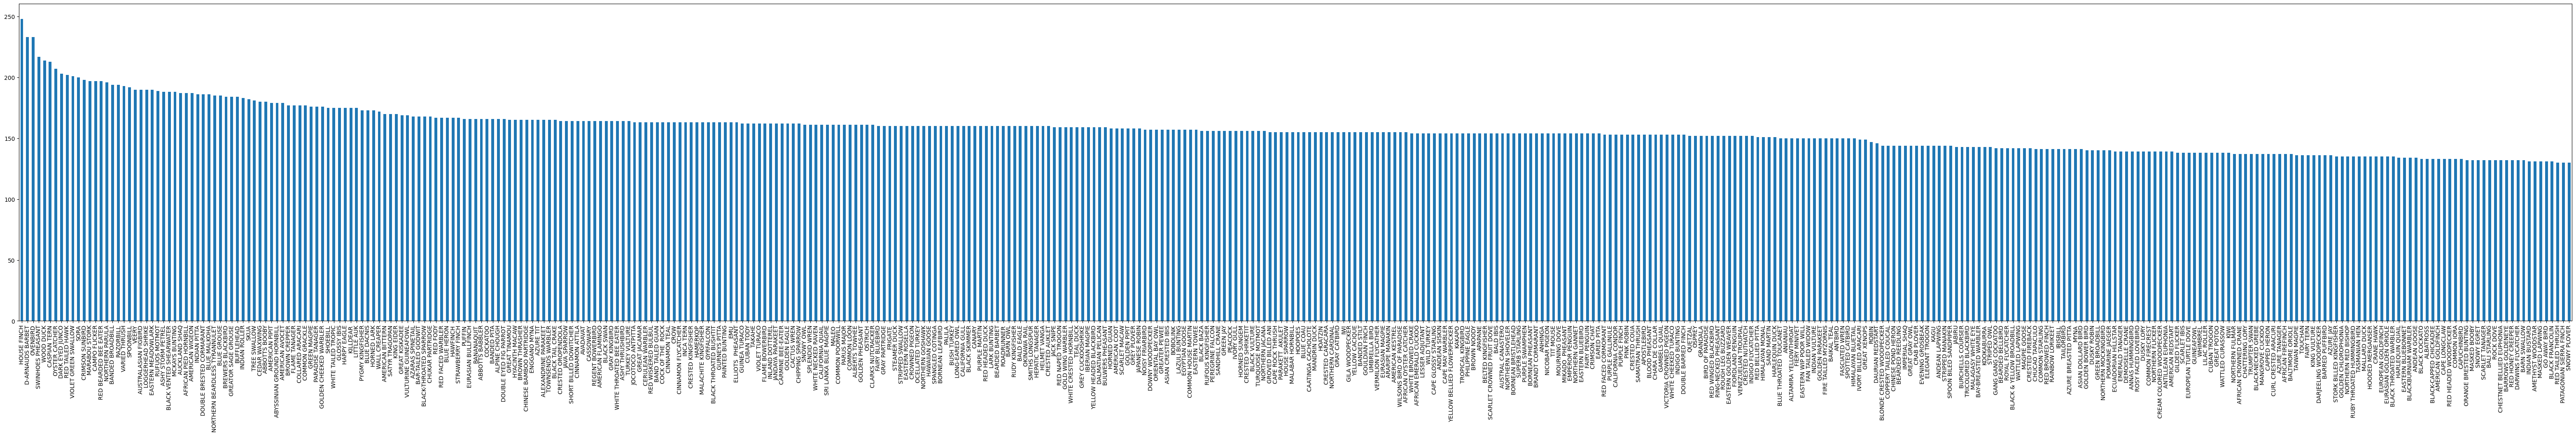

In [4]:
labels_train['labels'].value_counts().plot.bar(figsize=(80, 10));

If we roughly draw a line across the middle of the graph, we'd see there's about 150+ images for each bird breed/

This is a good amount as for some of their vision products [Google recommends a minimum of 10 images per class to get started](https://cloud.google.com/vision/automl/object-detection/docs/prepare). And as you might imagine, the more images per class available, the more chance a model has to figure out patterns between them.

Let's check out one of the images.

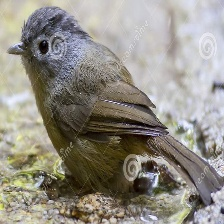

In [5]:
Image('data/train/ABBOTTS BABBLER/001.jpg')

### Getting images and their labels

Since we've got the image ID's and their labels in a DataFrame (`labels_train`), we'll use it to create:
* A list a filepaths to training images
* An array of all labels
* An array of all unique labels

We'll only create a list of filepaths to images rather than importing them all to begin with. This is because working with filepaths (strings) is much efficient than working with images.

In [6]:
#Create pathnames from image filepaths
filenames_train = ["data/" + fname for fname in labels_train["filepaths"]]

#Check the first 10 filenames
filenames_train[:10]

['data/train/ABBOTTS BABBLER/001.jpg',
 'data/train/ABBOTTS BABBLER/002.jpg',
 'data/train/ABBOTTS BABBLER/003.jpg',
 'data/train/ABBOTTS BABBLER/004.jpg',
 'data/train/ABBOTTS BABBLER/005.jpg',
 'data/train/ABBOTTS BABBLER/006.jpg',
 'data/train/ABBOTTS BABBLER/007.jpg',
 'data/train/ABBOTTS BABBLER/008.jpg',
 'data/train/ABBOTTS BABBLER/009.jpg',
 'data/train/ABBOTTS BABBLER/010.jpg']

In [7]:
import os
count = 0
for root_dir, cur_dir, files in os.walk('data/train'):  # train folder contains subdirectories (species) with about
    count += len(files)                                 # 150 jpgs for each species

if count == len(filenames_train):
  print("Filenames match actual amount of files!")
else:
  print("Filenames do not match actual amount of files, check the target directory.")

Filenames match actual amount of files!


Let's check if this worked. Visualizing directly from a filepath

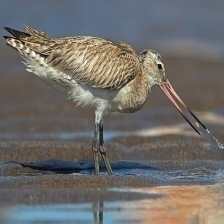

In [8]:
Image(filenames_train[9000])

Let's get the labels now.
We'll take them from `labels_train` and turn them into a NumPy array.

In [9]:
labels = labels_train['labels'].to_numpy()
labels[:10]

array(['ABBOTTS BABBLER', 'ABBOTTS BABBLER', 'ABBOTTS BABBLER',
       'ABBOTTS BABBLER', 'ABBOTTS BABBLER', 'ABBOTTS BABBLER',
       'ABBOTTS BABBLER', 'ABBOTTS BABBLER', 'ABBOTTS BABBLER',
       'ABBOTTS BABBLER'], dtype=object)

Same thing as before, let's check and compare the amount of labels to the number of filenames.

In [10]:
if len(labels) == len(filenames_train):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels does not match number of filenames, check data directories.")

Number of labels matches number of filenames!


If it all worked, we should have the same amount of images and labels.

Finally, since a machine learning model can't take strings as input (what `labels` currently is), we'll have to convert our labels to numbers.

To begin with, we'll find all the unique dog breed names.

Then we'll go through the list of `labels` and compare them to unique breeds and create a list of booleans indicating which one is the real label (`True`) and which ones aren't (`False`).

In [11]:
unique_breeds = np.unique(labels)
len(unique_breeds)

450

In [12]:
unique_breeds

array(['ABBOTTS BABBLER', 'ABBOTTS BOOBY', 'ABYSSINIAN GROUND HORNBILL',
       'AFRICAN CROWNED CRANE', 'AFRICAN EMERALD CUCKOO',
       'AFRICAN FIREFINCH', 'AFRICAN OYSTER CATCHER',
       'AFRICAN PIED HORNBILL', 'ALBATROSS', 'ALBERTS TOWHEE',
       'ALEXANDRINE PARAKEET', 'ALPINE CHOUGH', 'ALTAMIRA YELLOWTHROAT',
       'AMERICAN AVOCET', 'AMERICAN BITTERN', 'AMERICAN COOT',
       'AMERICAN FLAMINGO', 'AMERICAN GOLDFINCH', 'AMERICAN KESTREL',
       'AMERICAN PIPIT', 'AMERICAN REDSTART', 'AMERICAN WIGEON',
       'AMETHYST WOODSTAR', 'ANDEAN GOOSE', 'ANDEAN LAPWING',
       'ANDEAN SISKIN', 'ANHINGA', 'ANIANIAU', 'ANNAS HUMMINGBIRD',
       'ANTBIRD', 'ANTILLEAN EUPHONIA', 'APAPANE', 'APOSTLEBIRD',
       'ARARIPE MANAKIN', 'ASHY STORM PETREL', 'ASHY THRUSHBIRD',
       'ASIAN CRESTED IBIS', 'ASIAN DOLLARD BIRD', 'AUCKLAND SHAQ',
       'AUSTRAL CANASTERO', 'AUSTRALASIAN FIGBIRD', 'AVADAVAT',
       'AZARAS SPINETAIL', 'AZURE BREASTED PITTA', 'AZURE JAY',
       'AZURE TANAGER',

The length of `unique_breeds` should be 450, meaning we're working with images of 450 different breeds of birds.

Now use `unique_breeds` to help turn our `labels` array into an array of booleans.

In [13]:
# Example: Turn one label into an array of booleans
print(labels[0])
labels[0] == unique_breeds # use comparison operator to create boolean array

ABBOTTS BABBLER


array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

That's for one example, let's do the whole thing.

In [14]:
# Turn every label into a boolean array
boolean_labels_train = [label == np.array(unique_breeds) for label in labels]
boolean_labels_train[:2]

[array([ True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
      

Why do it like this?

Remember, an important concept in machine learning is converting your data to numbers before passing it to a machine learning model.

In this case, we've transformed a single bird breed name such as `ABBOTTS BABBLER` into a one-hot array.

Let's see an example.

In [15]:
# Example: Turning a boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])[0][0]) # index where label occurs
print(boolean_labels_train[0].argmax()) # index where label occurs in boolean array
print(boolean_labels_train[0].astype(int)) # there will be a 1 where the sample label occurs

ABBOTTS BABBLER
0
0
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]


## Now, preprocessing for the validation set
We will perform the same actions we did for the training set.

In [16]:
labels_validation = labels_csv.loc[(labels_csv['data set'] == 'valid') & labels_csv['labels']]    #Just validation set
filenames_valid = ["data/" + fname for fname in labels_validation["filepaths"]]
labels_valid = labels_validation['labels'].to_numpy()
unique_breeds_valid = np.unique(labels_valid)
boolean_labels_valid = [label == np.array(unique_breeds_valid) for label in labels_valid]

Let's check to see if everything is working

In [17]:
# Example: Turning a boolean array into integers
print(labels_valid[0]) # original label
print(np.where(unique_breeds_valid == labels_valid[0])[0][0]) # index where label occurs
print(boolean_labels_valid[0].argmax()) # index where label occurs in boolean array
print(boolean_labels_valid[0].astype(int)) # there will be a 1 where the sample label occurs

ABBOTTS BABBLER
0
0
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]


In [18]:
X_train = filenames_train
y_train = boolean_labels_train
X_val = filenames_valid
y_val = boolean_labels_valid
len(X_train), len(y_train), len(X_val), len(y_val)

(70626, 70626, 2250, 2250)

In [19]:
# Check out the training data (image file paths and labels
X_train[:5], y_train[:5]

(['data/train/ABBOTTS BABBLER/001.jpg',
  'data/train/ABBOTTS BABBLER/002.jpg',
  'data/train/ABBOTTS BABBLER/003.jpg',
  'data/train/ABBOTTS BABBLER/004.jpg',
  'data/train/ABBOTTS BABBLER/005.jpg'],
 [array([ True, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
       

### Transforming data with `torchvision.transform`

We've got folders of images, but before we can use them with PyTorch, we need to convert them into tensors.

One of the ways we can do this is by using the `torchvision.transforms` module.

`torchvision.transforms` contains many pre-built methods for formatting images, turing them into tensors and even manipulating them for **data augmentation** (the practice of altering data to make it harder for a model to learn) purposes.

To get experience with `torchvision.transform`, let's write a series of transforms that:
1. Resize the images using transform.Resize() (from 224x224 to 150x150)
2. Flip our images on the horizontal using transforms.RandomHorizontalFlip() (
3. Turn our images from a PIL image to a PyTorch tensor using transforms.ToTensor()

We can compile all of these steps using `torchvision.transforms.Compose()`.

**Note**: If you are running this **locally**, follow these [instructions](https://pytorch.org/get-started/locally/) to set up PyTorch and also make sure you have [CUDA Toolkit 12.0](https://developer.nvidia.com/cuda-downloads?target_os=Windows&target_arch=x86_64&target_version=10&target_type=exe_network) - more info at [CUDA NVIDIA (for windows)](https://docs.nvidia.com/cuda/cuda-installation-guide-microsoft-windows/index.html)

In [20]:
import random
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image
from pathlib import Path
data_transforms = {
    'train': transforms.Compose([
        # Resize the images to 150x150
        transforms.Resize(size=(150,150)),
        # Flip the images randomly on the horizontal
        transforms.RandomHorizontalFlip(p=0.5),
        # Turn the image into a torch.Tensor
        transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=(150,150)),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=(150,150)),
        transforms.ToTensor(),
    ])
}

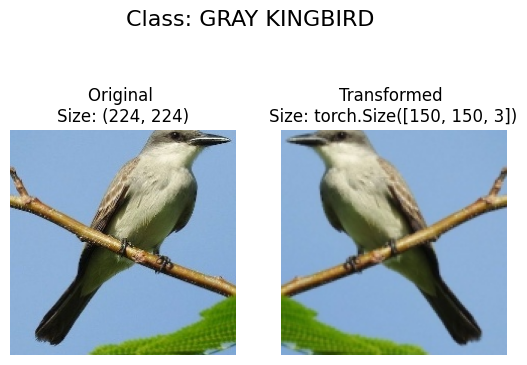

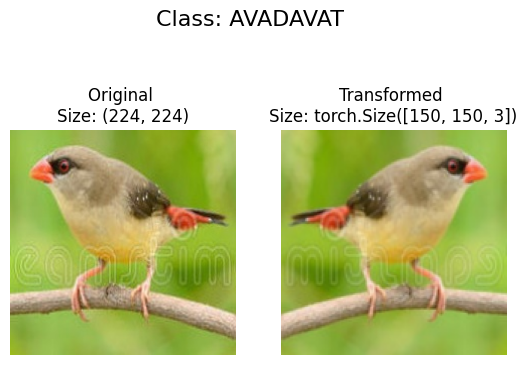

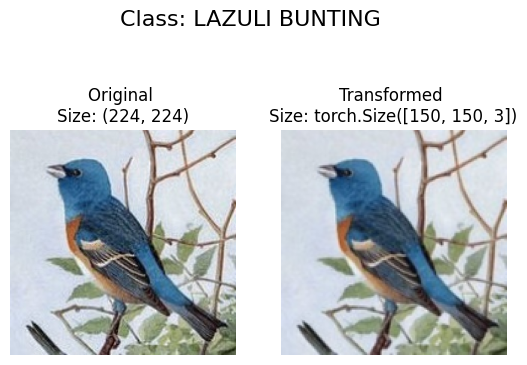

In [21]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """ Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transforms
    them with torchvision.transforms and plot them side by side.

    :param image_paths: List of target image paths
    :param transform: PyTorch Transforms (https://pytorch.org/vision/stable/transforms.html) to apply to the images.
    :param n: Numer of images to plot. Default set to 3.
    :param seed: Random seed for the random generator. Default set to 42.
    :return: void
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f'Original \nSize: {f.size}')
            ax[0].axis('off')

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C]
            transformed_image = transform(f).permute(1,2,0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f'Transformed \nSize: {transformed_image.shape}')
            ax[1].axis('off')

            fig.suptitle(f'Class: {Path(image_path).parent.stem}', fontsize=16)

plot_transformed_images(
    image_paths=filenames_train,
    transform=data_transforms['train'],
    n=3,
    seed=None
)

Now we've got a composition of transforms, let's write a function to try them out on various images

## Loading Image Data Using `ImageFolder`
Alright, time to turn our image data into a `Dataset` capable of being used with PyTorch.

Since our data is in standard image classification format, we can use the class `torchvision.datasets.ImageFolder`.

Where we can pass it the file path of a target image directory as well as a series of transforms we'd like to perform on our images.

Let's test it out on our data folders `train_dir` and `test_dir` passing `transform=data_transform` to turn our images into tensors.

In [22]:
data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid','test']}
print(f"Train data:\n{image_datasets['train']}\nValidation data: {image_datasets['valid']}\nTest data:\n{image_datasets['test']}")

Train data:
Dataset ImageFolder
    Number of datapoints: 70626
    Root location: data\train
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Validation data: Dataset ImageFolder
    Number of datapoints: 2250
    Root location: data\valid
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 2250
    Root location: data\test
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )


Perfect!

It looks like PyTorch has registered our `Dataset`'s.

Let's inspect them by checking out the `classes` and `class_to_idx` attributes as well as the lengths of our training and test sets.

In [23]:
# Get class names as a list
class_names = image_datasets['train'].classes
class_names

['ABBOTTS BABBLER',
 'ABBOTTS BOOBY',
 'ABYSSINIAN GROUND HORNBILL',
 'AFRICAN CROWNED CRANE',
 'AFRICAN EMERALD CUCKOO',
 'AFRICAN FIREFINCH',
 'AFRICAN OYSTER CATCHER',
 'AFRICAN PIED HORNBILL',
 'ALBATROSS',
 'ALBERTS TOWHEE',
 'ALEXANDRINE PARAKEET',
 'ALPINE CHOUGH',
 'ALTAMIRA YELLOWTHROAT',
 'AMERICAN AVOCET',
 'AMERICAN BITTERN',
 'AMERICAN COOT',
 'AMERICAN FLAMINGO',
 'AMERICAN GOLDFINCH',
 'AMERICAN KESTREL',
 'AMERICAN PIPIT',
 'AMERICAN REDSTART',
 'AMERICAN WIGEON',
 'AMETHYST WOODSTAR',
 'ANDEAN GOOSE',
 'ANDEAN LAPWING',
 'ANDEAN SISKIN',
 'ANHINGA',
 'ANIANIAU',
 'ANNAS HUMMINGBIRD',
 'ANTBIRD',
 'ANTILLEAN EUPHONIA',
 'APAPANE',
 'APOSTLEBIRD',
 'ARARIPE MANAKIN',
 'ASHY STORM PETREL',
 'ASHY THRUSHBIRD',
 'ASIAN CRESTED IBIS',
 'ASIAN DOLLARD BIRD',
 'AUCKLAND SHAQ',
 'AUSTRAL CANASTERO',
 'AUSTRALASIAN FIGBIRD',
 'AVADAVAT',
 'AZARAS SPINETAIL',
 'AZURE BREASTED PITTA',
 'AZURE JAY',
 'AZURE TANAGER',
 'AZURE TIT',
 'BAIKAL TEAL',
 'BALD EAGLE',
 'BALD IBIS',
 'BALI

In [24]:
class_dict = image_datasets['train'].class_to_idx
class_dict

{'ABBOTTS BABBLER': 0,
 'ABBOTTS BOOBY': 1,
 'ABYSSINIAN GROUND HORNBILL': 2,
 'AFRICAN CROWNED CRANE': 3,
 'AFRICAN EMERALD CUCKOO': 4,
 'AFRICAN FIREFINCH': 5,
 'AFRICAN OYSTER CATCHER': 6,
 'AFRICAN PIED HORNBILL': 7,
 'ALBATROSS': 8,
 'ALBERTS TOWHEE': 9,
 'ALEXANDRINE PARAKEET': 10,
 'ALPINE CHOUGH': 11,
 'ALTAMIRA YELLOWTHROAT': 12,
 'AMERICAN AVOCET': 13,
 'AMERICAN BITTERN': 14,
 'AMERICAN COOT': 15,
 'AMERICAN FLAMINGO': 16,
 'AMERICAN GOLDFINCH': 17,
 'AMERICAN KESTREL': 18,
 'AMERICAN PIPIT': 19,
 'AMERICAN REDSTART': 20,
 'AMERICAN WIGEON': 21,
 'AMETHYST WOODSTAR': 22,
 'ANDEAN GOOSE': 23,
 'ANDEAN LAPWING': 24,
 'ANDEAN SISKIN': 25,
 'ANHINGA': 26,
 'ANIANIAU': 27,
 'ANNAS HUMMINGBIRD': 28,
 'ANTBIRD': 29,
 'ANTILLEAN EUPHONIA': 30,
 'APAPANE': 31,
 'APOSTLEBIRD': 32,
 'ARARIPE MANAKIN': 33,
 'ASHY STORM PETREL': 34,
 'ASHY THRUSHBIRD': 35,
 'ASIAN CRESTED IBIS': 36,
 'ASIAN DOLLARD BIRD': 37,
 'AUCKLAND SHAQ': 38,
 'AUSTRAL CANASTERO': 39,
 'AUSTRALASIAN FIGBIRD': 40,
 '

In [25]:
len(image_datasets['train']), len(image_datasets['valid']), len(image_datasets['test'])

(70626, 2250, 2250)

Great! Looks like we'll be able to use these to reference for later.

How about our images and labels?

How do they look?

We can index on our `train_data` and `test_data` `Dataset`'s to find samples and their target labels.

In [26]:
img, label = image_datasets['train'][0][0], image_datasets['train'][0][ 1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.6980, 0.7098, 0.7333,  ..., 0.7608, 0.7373, 0.7176],
         [0.7059, 0.7137, 0.7294,  ..., 0.7765, 0.7608, 0.7373],
         [0.7137, 0.7137, 0.7294,  ..., 0.7922, 0.7804, 0.7529],
         ...,
         [0.6745, 0.7098, 0.7176,  ..., 0.8000, 0.7569, 0.7255],
         [0.6863, 0.7176, 0.6235,  ..., 0.6941, 0.6745, 0.6275],
         [0.6471, 0.6902, 0.6392,  ..., 0.6824, 0.6353, 0.6157]],

        [[0.7020, 0.7098, 0.7294,  ..., 0.7373, 0.7098, 0.6863],
         [0.7059, 0.7098, 0.7255,  ..., 0.7490, 0.7373, 0.7059],
         [0.7098, 0.7098, 0.7255,  ..., 0.7647, 0.7529, 0.7216],
         ...,
         [0.6627, 0.7020, 0.7216,  ..., 0.7569, 0.7098, 0.6745],
         [0.6863, 0.7216, 0.6353,  ..., 0.6471, 0.6235, 0.5725],
         [0.6627, 0.7020, 0.6549,  ..., 0.6353, 0.5843, 0.5529]],

        [[0.7804, 0.7804, 0.7961,  ..., 0.6510, 0.6235, 0.6000],
         [0.7804, 0.7765, 0.7882,  ..., 0.6706, 0.6588, 0.6275],
         [0.7804, 0.7725, 0.7843,  ..., 0.69

Our images are now in the form of a tensor (with shape [3, 150, 150]) and the labels are in the form of an integer relating to a specific class (as referenced by the `class_to_idx` attribute).

How about we plot a single image tensor using `matplotlob`?

We'll first have to permute (rearrange the order of its dimensions) so it's compatible.

Right now our image dimensions are in the format `CHW` (color channels, height, width) but `matplotlib` prefers `HWC` (height, width, color channels).

Original shape: torch.Size([3, 150, 150]) -> [color_channels, height, width]
Image permute shape: torch.Size([150, 150, 3]) -> [height, width, color_channel]


Text(0.5, 1.0, 'ABBOTTS BABBLER')

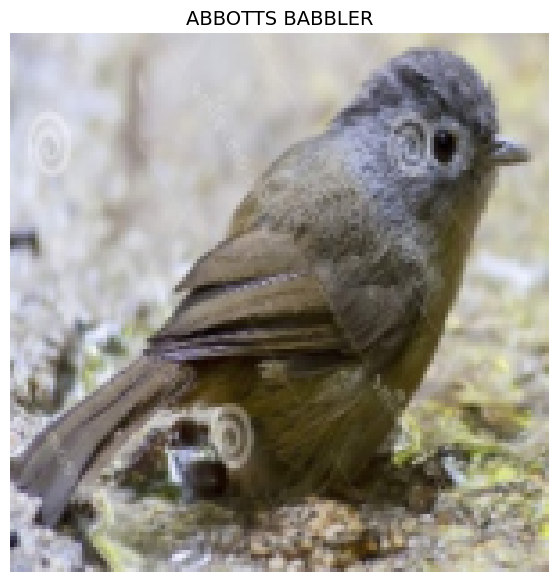

In [27]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Prints out different shapes (before and after permute)
print(f'Original shape: {img.shape} -> [color_channels, height, width]')
print(f'Image permute shape: {img_permute.shape} -> [height, width, color_channel]')

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.title(class_names[label], fontsize=14)

Notice the image is now more pixelated (less quality)

This is due to it being resized from `224x224` to `150x150` pixels.

The intuition here is that if you think the image is harder to recognize what's going on, chances are a model will find it harder to understand too.

## Turn loaded images into `DataLoader`'s

We've got our images as PyTorch `Dataset`'s but now let's turn them into `DataLoader`'s.

We'll do so using `torch.utils.data.DataLoader`.

Turing our `Dataset`'s into `DataLoader`'s makes them iterable so a model can go through learn the relationships between samples and targets (features and labels).

To keep things simple, we'll use a `batch_size=1` and `num_workers=1`.

What's `num_workers`?

Good question.

It defines how many subprocesses will be created to load your data.

Think of it like this, the higher value `num_workers` is set to, the more compute power PyTorch will use to load your data.

Personally, I usually set it to the total number of CPUs on my machine via Python's `os.cpu_count()`.

This ensures the `DataLoader` recruits as many cores as possible to load data.

**Note:** There are more parameters you can get familiar with using `torch.utils.data.DataLoader` in the PyTorch [documentation](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)


In [28]:
os.cpu_count()

8

In [29]:
# Turn train and test Datasets into DataLoader
train_dataloader = DataLoader(dataset=image_datasets['train'],
                              batch_size=16,    # how many samples per batch?
                              num_workers=8,    # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True)     # shuffle the data?

valid_dataloader = DataLoader(dataset=image_datasets['valid'],
                             batch_size=16,
                             num_workers=8,
                             shuffle=False) # don't usually need to shuffle validation data

test_dataloader = DataLoader(dataset=image_datasets['valid'],
                             batch_size=16,
                             num_workers=8,
                             shuffle=False) # don't usually need to shuffle testing data

# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid','test']}
# class_names = image_datasets['train'].classes

train_dataloader, valid_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1411f7512e0>,
 <torch.utils.data.dataloader.DataLoader at 0x1411f751310>)

Now our data is iterable.

Let's try it out and check the shapes.

In [30]:
img, label = next(iter(train_dataloader))

# Batch size will now be 32, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([16, 3, 150, 150]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([16])


We could now use these `DataLoader`'s with a training and testing loop to train a model.

But before we do, let's look at another option to load images (or almost any other kind of data).

## Other forms of transforms (data augmentation)

**Data augmentation** is the process of artificially adding diversity to your training data.

In the case of image data, this may mean applying various image transformation to the training images.

This practice hopefully results in a model that's more generalizable to unseen data.

Here is an example of **RandAugment** from PyTorch's documentation on [data augmentation](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py):

![RandAugment](https://pytorch.org/vision/stable/_images/sphx_glr_plot_transforms_021.png)

### Let's take a look at one particular type of [data augmentation](https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/) used to train PyTorch vision models to state-of-the-art levels

[Blog post](https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/)

In [31]:
# Paper on trivial augment - https://arxiv.org/abs/2103.10158
data_transforms['train'] = transforms.Compose([
    transforms.Resize(size=(150,150)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

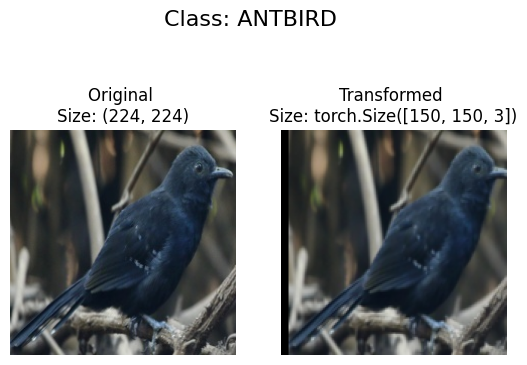

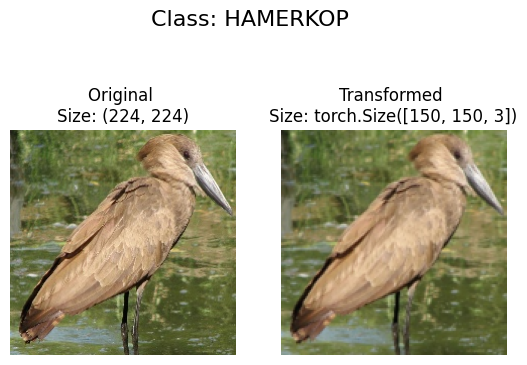

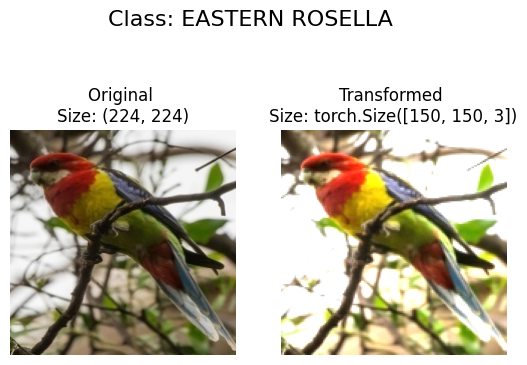

In [32]:
# Plot random transformed images
plot_transformed_images(
    image_paths=filenames_train,
    transform=data_transforms['train'],
    n=3,
    seed=None
)

# Model 0: [TinyVGG](https://poloclub.github.io/cnn-explainer/) without data augmentation
## Creating transforms and loading data for Model 0

In [33]:
# Create simple transform
data_transforms.update({'simple_transform': transforms.Compose([
    transforms.Resize(size=(150, 150)),
    transforms.ToTensor()
])})
print(data_transforms)

{'train': Compose(
    Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ToTensor()
), 'valid': Compose(
    Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
), 'test': Compose(
    Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
), 'simple_transform': Compose(
    Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)}


In [34]:
# 1. Load and transform data
image_datasets.update({'train_simple':datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                          transform=data_transforms['simple_transform'])})

# 2. Turn the datasets into DataLoader
BATCH_SIZE = 16
NUM_WORKERS = os.cpu_count()

# Create DataLoaders
train_dataloader_simple = DataLoader(dataset=image_datasets['train_simple'],
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=True)

In [35]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from CNN Explainer: https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
        super(TinyVGG, self).__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)  #default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)  #default stride value is same as kernel_size
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*34*34,
                      out_features=output_shape)
        )

    def forward(self, x):
        # x = self.conv_block_1(x)
        # # print(x.shape)
        # x = self.conv_block_2(x)
        # # print(x.shape)
        # x = self.classifier(x)
        # # print(x.shape)
        # return x
        return self.classifier(self.conv_block_2(self.conv_block_1(x))) # benefits from operator fusion

In [36]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,    # number of color channels in our image data
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=11560, out_features=450, bias=True)
  )
)

### Try a forward pass on a single image to test if the forward pass works

In [37]:
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([16, 3, 150, 150]), torch.Size([16]))

In [38]:
# Try a forward pass
model_0(image_batch.to(device))

tensor([[-0.0145, -0.0469,  0.0290,  ...,  0.0082,  0.1071,  0.0881],
        [-0.0146, -0.0504,  0.0278,  ...,  0.0113,  0.1093,  0.0923],
        [-0.0177, -0.0467,  0.0296,  ...,  0.0122,  0.1086,  0.0909],
        ...,
        [-0.0132, -0.0498,  0.0288,  ...,  0.0111,  0.1093,  0.0884],
        [-0.0211, -0.0482,  0.0266,  ...,  0.0104,  0.1104,  0.0939],
        [-0.0187, -0.0491,  0.0298,  ...,  0.0107,  0.1136,  0.0926]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

### Use `torchinfo` to get an idea of the shapes going through the model

In [39]:
from torchinfo import summary
summary(model_0, input_size=[1,3,150,150])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 450]                  --
├─Sequential: 1-1                        [1, 10, 73, 73]           --
│    └─Conv2d: 2-1                       [1, 10, 148, 148]         280
│    └─ReLU: 2-2                         [1, 10, 148, 148]         --
│    └─Conv2d: 2-3                       [1, 10, 146, 146]         910
│    └─ReLU: 2-4                         [1, 10, 146, 146]         --
│    └─MaxPool2d: 2-5                    [1, 10, 73, 73]           --
├─Sequential: 1-2                        [1, 10, 34, 34]           --
│    └─Conv2d: 2-6                       [1, 10, 71, 71]           910
│    └─ReLU: 2-7                         [1, 10, 71, 71]           --
│    └─Conv2d: 2-8                       [1, 10, 69, 69]           910
│    └─ReLU: 2-9                         [1, 10, 69, 69]           --
│    └─MaxPool2d: 2-10                   [1, 10, 34, 34]           --
├─Sequentia

### Create train and test loops functions

* `train_step()` - takes in a model and dta loader and trains the model on the dataloader.
* `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader.

In [40]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put the model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # Send data to the target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate the loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate accuracy metric
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class==y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [41]:
# Create test_step()
def test_step(model:torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference mode
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to the target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate the loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate the accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))

        # Adjust metrics to get average loss and accuracy per batch
        test_loss = test_loss / len(dataloader)
        test_acc = test_acc / len(dataloader)
        return test_loss, test_acc

### Creating a `train()` function to combine `train_step()` and `test_step()`

In [42]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer +
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    # 2. Create empty results dictionary
    results = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):

        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn)
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )
        # 5. Update results dictionary
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

### Train and evaluate Model 0

In [43]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f'Total training time: {end_time-start_time:.3f} seconds')


  0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Plot the loss curves for Model 0

From the print out of our `Model 0`, it didn't look like it did too well.

But we can further evaluate it byu plotting the model's **loss curves**.

**Loss curves** show the model's results over time.

And they're a great way to see how your model performs on different datasets (e.g. training and test).

Let's create a function to plot the values in our `model_0_results` dictionary.

In [ ]:
model_0_results.keys()

We'll extract each of these keys and turn them into a plot.

In [ ]:
from typing import Tuple, Dict, List
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Figure out how accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

In [ ]:
plot_loss_curves(model_0_results)